In [58]:
%load_ext autoreload
%autoreload 2

import asyncio, copy, cv2, dlib, os, socket, sys, time
from functools import partial
from multiprocessing import Pool, Process
from pathlib import Path
from tqdm import tqdm

import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import shap
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../../")))
from libs import nn, resnet, sim, helper
#from cfgs.fedargs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# Device settings
use_cuda = torch.cuda.is_available()
torch.manual_seed(10)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

In [60]:
def shap_plot(explain, img, size):
    #shap_image = g_img.unsqueeze(0)
    shap_values = explain.shap_values(img.unsqueeze(0))
    
    shap_tensor = torch.tensor(shap_values)
    shap_lists = []
    for i in range(2):
        lsum = 0
        lst = shap_tensor[i].squeeze(0).squeeze(0).view(size).tolist()
        shap_lists.append(lst)
        for l in lst:
            if l > 0:
                lsum += abs(l)
        print ('shap_sum', lsum)
    
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(img.unsqueeze(0).numpy(), 1, -1), 1, 2)
    shap.image_plot(shap_numpy, -test_numpy, None, 20, 0.2, 0.2, None, False)
    #shap.image_plot(shap_values, -shap_image)
    return shap_values

<h1>Gender: ResNet</h1>

In [61]:
df = pd.read_csv('../../data/celeba/list_attr_celeba.txt', sep="\s+", skiprows=1, usecols=['Male', 'Smiling'])

df1 = df[df['Smiling'] == 1]

df1 = df1[['Male']]
print(len(df), len(df1))

# Make 0 (female) & 1 (male) labels instead of -1 & 1
df1.loc[df1['Male'] == -1, 'Male'] = 0

df1.tail()

202599 97669


,Male
202592.jpg,0
202593.jpg,0
202596.jpg,1
202597.jpg,1
202598.jpg,0


In [62]:
df2 = pd.read_csv('../../data/celeba/list_eval_partition.txt', sep="\s+", skiprows=0, header=None)
df2.columns = ['Filename', 'Partition']
df2 = df2.set_index('Filename')

df2.tail()

,Partition
Filename,
202595.jpg,2
202596.jpg,2
202597.jpg,2
202598.jpg,2
202599.jpg,2


In [63]:
df3 = df1.merge(df2, left_index=True, right_index=True)
df3.tail()

,Male,Partition
202592.jpg,0,2
202593.jpg,0,2
202596.jpg,1,2
202597.jpg,1,2
202598.jpg,0,2


In [64]:
df3.to_csv('celeba-gender-partitions.csv')
df4 = pd.read_csv('celeba-gender-partitions.csv', index_col=0)
df4.tail()

,Male,Partition
202592.jpg,0,2
202593.jpg,0,2
202596.jpg,1,2
202597.jpg,1,2
202598.jpg,0,2


In [65]:
df4.loc[df4['Partition'] == 0].to_csv('celeba-gender-train.csv')
df4.loc[df4['Partition'] == 1].to_csv('celeba-gender-valid.csv')
df4.loc[df4['Partition'] == 2].to_csv('celeba-gender-test.csv')

(218, 178, 3)


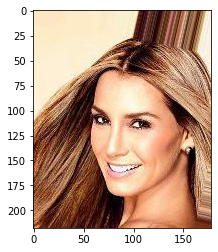

In [66]:
img = Image.open('../../data/celeba/img_align_celeba/000001.jpg')
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

In [67]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [68]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally
BATCH_SIZE = 256

custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((128, 128)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = CelebaDataset(csv_path='celeba-gender-train.csv',
                              img_dir='../../data/celeba/img_align_celeba/',
                              transform=custom_transform)

valid_dataset = CelebaDataset(csv_path='celeba-gender-valid.csv',
                              img_dir='../../data/celeba/img_align_celeba/',
                              transform=custom_transform)

test_dataset = CelebaDataset(csv_path='celeba-gender-test.csv',
                             img_dir='../../data/celeba/img_align_celeba/',
                             transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

In [71]:
target_model = resnet.ResNet18(2)
#MS_FS
#target_model.load_state_dict(torch.load("../../out/models/PIA_sunglass/TM(MS_2k_FS_2k)_3e_pth", map_location ='cpu'))
#MNS_FNS
#target_model.load_state_dict(torch.load("../../out/models/PIA_sunglass/TM(MNS_2k_FNS_2k)_3e_pth", map_location ='cpu'))
#MNS_FS
#target_model.load_state_dict(torch.load("../../out/models/PIA_result/TM(MNS_30K_FS_30K)_pth", map_location ='cpu'))
#MS_FNS
target_model.load_state_dict(torch.load("../../out/models/PIA_sunglass/TM(MS_2k_FNS_2k)_3e_pth", map_location ='cpu'))
#MS_30_MNS_10_FS_30_FNS_10
#target_model.load_state_dict(torch.load("../../out/models/PIA_result/TM(MS_30K_MNS_10K_FS_30K_FNS_10K)_pth", map_location ='cpu'))
#MS_10_MNS_30_FS_10_FNS_30
#target_model.load_state_dict(torch.load("../../out/models/PIA_HK/TM(MS_30K_FS_30K)_3E_HK.pth", map_location ='cpu'))
target_model.eval()
print("Model Loaded")

Model Loaded


<h1>SHAP Explain</h1>

In [72]:
target_batch = next(iter(test_loader))
target_images, target_labels = target_batch
target_baseline = target_images
    
target_explain = shap.DeepExplainer(target_model, target_baseline)
#plt.imshow(target_images[0])

In [73]:
r_img = torch.tensor([[[0.0 for col in range(128)] for row in range(128)] for dim in range(3)])
#z_img = z_img.reshape(1,28,28)
r_img.shape
#plt.imshow(z_img.numpy().squeeze())

torch.Size([3, 128, 128])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


shap_sum 5278.264132543596
shap_sum 6049.958442872887


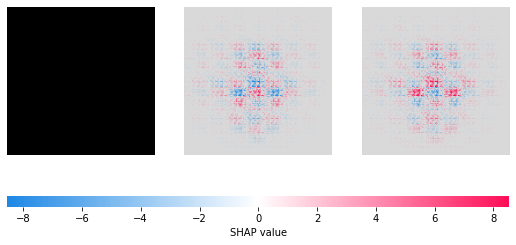

In [74]:
target_shap_values = shap_plot(target_explain, r_img, 49152)
target_female = torch.tensor(target_shap_values[0]).view(-1) 
target_male = torch.tensor(target_shap_values[1]).view(-1)

<h1>SM1</h1>

shap_sum 315.68254871142494
shap_sum 331.52234222441257


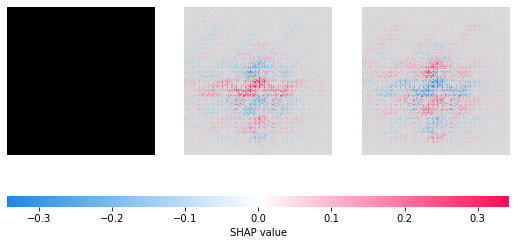

In [75]:
sm1_model = resnet.ResNet18(2)
sm1_model.load_state_dict(torch.load("../../out/models/PIA_sunglass/sm(ms500_fs500)_3e_hk.pth", map_location ='cpu'))
sm1_model.eval()
sm1_explain = shap.DeepExplainer(sm1_model, target_baseline)
sm1_shap_values = shap_plot(sm1_explain, r_img, 49152)
sm1_female = torch.tensor(sm1_shap_values[0]).view(-1) 
sm1_male = torch.tensor(sm1_shap_values[1]).view(-1)

<h1>SM2</h1>

shap_sum 1857.6413670618222
shap_sum 2091.2785872637505


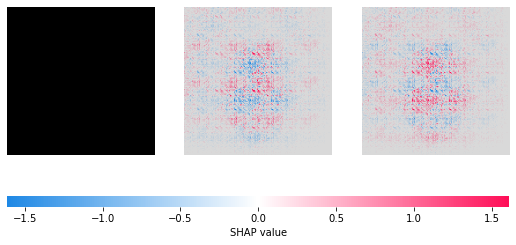

In [76]:
sm2_model = resnet.ResNet18(2)
sm2_model.load_state_dict(torch.load("../../out/models/PIA_sunglass/sm_(mns_500_fns_500)_3e.pth", map_location ='cpu'))
sm2_model.eval()
sm2_explain = shap.DeepExplainer(sm2_model, target_baseline)
sm2_shap_values = shap_plot(sm2_explain, r_img, 49152)
sm2_female = torch.tensor(sm2_shap_values[0]).view(-1) 
sm2_male = torch.tensor(sm2_shap_values[1]).view(-1)

<h1>SM3</h1>

shap_sum 544.5129402715199
shap_sum 523.9210127774827


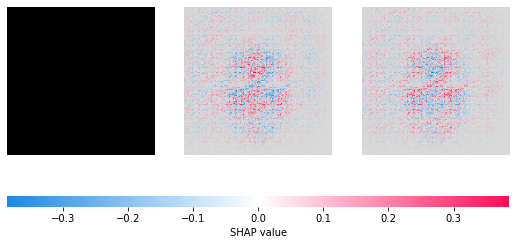

In [77]:
sm3_model = resnet.ResNet18(2)
sm3_model.load_state_dict(torch.load("../../out/models/PIA_sunglass/sm_(ms_500_fns_500)_3e.pth", map_location ='cpu'))
sm3_model.eval()
sm3_explain = shap.DeepExplainer(sm3_model, target_baseline)
sm3_shap_values = shap_plot(sm3_explain, r_img, 49152)
sm3_female = torch.tensor(sm3_shap_values[0]).view(-1) 
sm3_male = torch.tensor(sm3_shap_values[1]).view(-1)

<h1>SM4</h1>

shap_sum 258.55985424865685
shap_sum 309.72943734513916


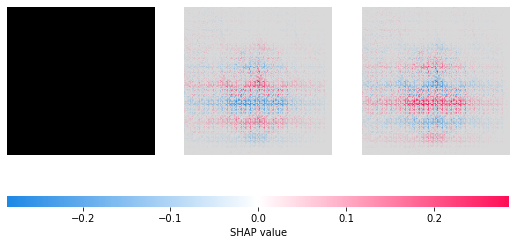

In [78]:
sm4_model = resnet.ResNet18(2)
sm4_model.load_state_dict(torch.load("../../out/models/PIA_sunglass/sm_(mns_500_fs_500)_3e.pth", map_location ='cpu'))
sm4_model.eval()
sm4_explain = shap.DeepExplainer(sm4_model, target_baseline)
sm4_shap_values = shap_plot(sm4_explain, r_img, 49152)
sm4_female = torch.tensor(sm4_shap_values[0]).view(-1) 
sm4_male = torch.tensor(sm4_shap_values[1]).view(-1)

<h1>SM5</h1>

In [79]:
''''
sm5_model = resnet.ResNet18(2)
sm5_model.load_state_dict(torch.load("../../out/models/PIA_sunglass/TM(MS_1500_MNS_500_FS_1500_FNS_500)_3e_pth", map_location ='cpu'))
sm5_model.eval()
sm5_explain = shap.DeepExplainer(sm5_model, target_baseline)
sm5_shap_values = shap_plot(sm5_explain, r_img, 49152)
sm5_female = torch.tensor(sm5_shap_values[0]).view(-1) 
sm5_male = torch.tensor(sm5_shap_values[1]).view(-1)

'''

'\'\nsm5_model = resnet.ResNet18(2)\nsm5_model.load_state_dict(torch.load("../../out/models/PIA_sunglass/TM(MS_1500_MNS_500_FS_1500_FNS_500)_3e_pth", map_location =\'cpu\'))\nsm5_model.eval()\nsm5_explain = shap.DeepExplainer(sm5_model, target_baseline)\nsm5_shap_values = shap_plot(sm5_explain, r_img, 49152)\nsm5_female = torch.tensor(sm5_shap_values[0]).view(-1) \nsm5_male = torch.tensor(sm5_shap_values[1]).view(-1)\n\n'

<h1>SM6</h1>

In [80]:
'''
sm6_model = resnet.ResNet18(2)
sm6_model.load_state_dict(torch.load("../../out/models/PIA_sunglass/TM(MS_500_MNS_1500_FS_500_FNS_1500)_3e_pth", map_location ='cpu'))
sm6_model.eval()
sm6_explain = shap.DeepExplainer(sm6_model, target_baseline)
sm6_shap_values = shap_plot(sm6_explain, r_img, 49152)
sm6_female = torch.tensor(sm6_shap_values[0]).view(-1) 
sm6_male = torch.tensor(sm6_shap_values[1]).view(-1)
'''

'\nsm6_model = resnet.ResNet18(2)\nsm6_model.load_state_dict(torch.load("../../out/models/PIA_sunglass/TM(MS_500_MNS_1500_FS_500_FNS_1500)_3e_pth", map_location =\'cpu\'))\nsm6_model.eval()\nsm6_explain = shap.DeepExplainer(sm6_model, target_baseline)\nsm6_shap_values = shap_plot(sm6_explain, r_img, 49152)\nsm6_female = torch.tensor(sm6_shap_values[0]).view(-1) \nsm6_male = torch.tensor(sm6_shap_values[1]).view(-1)\n'

# cosine similarity 

In [81]:
print(sim.cosine_similarity(target_female, sm1_female))
print(sim.cosine_similarity(target_female, sm2_female))
print(sim.cosine_similarity(target_female, sm3_female))
print(sim.cosine_similarity(target_female, sm4_female))
#print(sim.cosine_similarity(target_female, sm5_female))
#print(sim.cosine_similarity(target_female, sm6_female))

-0.12292569
0.07865763
0.16299057
-0.16459931


In [82]:
print(sim.cosine_similarity(target_male, sm1_male))
print(sim.cosine_similarity(target_male, sm2_male))
print(sim.cosine_similarity(target_male, sm3_male))
print(sim.cosine_similarity(target_male, sm4_male))
#print(sim.cosine_similarity(target_male, sm5_male))
#print(sim.cosine_similarity(target_male, sm6_male))

-0.12194575
0.07903871
0.16301675
-0.16517262
